In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from typing import List
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from functools import partial

In [2]:
# Define the path to your Parquet file or directory
dataPath = "data_clean1.parquet"  # Adjust for single file or directory
# Read the Parquet data into a DataFrame
df_model = pd.read_parquet(dataPath)

In [20]:
X = df_model.drop(["timestamp_rounded", "label"], axis=1)
y = df_model["label"].map({"Interrupted": 1, "Continue": 0})

In [4]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64", "float32"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Define the numerical transformer
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", StandardScaler()),
    ]
)

# Define the categorical transformer (if you have categorical features)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

## Basic model - Logistic regression

In [12]:
pipeline_lg = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(max_iter=10000)),
    ]
)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
pipeline_lg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['col_0_numeric', 'col_1_numeric', 'col_2_numeric', 'col_3_numeric',
       'col_4_numeric', 'col_5_numeric', 'col_6_numeric', 'col_7_numeric',
       'col_8_numeric', 'col_9_numeric',
       ...
       'co...
       'col_321_numeric', 'col_323_numeric', 'col_324_numeric',
       'col_325_numeric'],
      dtype='object', length=286)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=10000))])

In [45]:
y_pred = pipeline_lg.predict(X_test)
y_pred_proba = pipeline_lg.predict_proba(X_test)[:, 1]

In [47]:
fpr, tpr, roc_auc = model_metrics(y_test, y_pred, y_pred_proba)

Confusion Matrix:
[[181314  58746]
 [  3293  13216]]
Recall: 0.82
Precision: 0.76
ROC AUC: 0.8545788462529611


In [39]:
def model_metrics(y_test, y_pred, y_pred_proba):
    """Model evaluation metrics for classification model"""

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    recall = cm[0, 1] / (cm[0, 1] + cm[1, 1])
    print(f"Recall: {recall:.2f}")

    precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print(f"Precision: {precision:.2f}")
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc}")

    return fpr, tpr, roc_auc

In [27]:
# Plot ROC Curve
def plot_roc_curve(fpr: List, tpr: List, roc_auc: int):
    """Function to plot ROC curve"""

    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

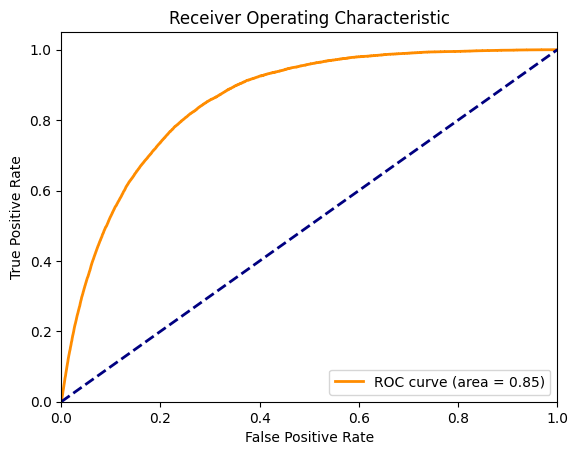

In [29]:
plot_roc_curve(fpr, tpr, roc_auc)

## State of art model - XGBoosting

In [34]:
pipeline_xgb = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier()),
    ]
)

In [35]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['col_0_numeric', 'col_1_numeric', 'col_2_numeric', 'col_3_numeric',
       'col_4_numeric', 'col_5_numeric', 'col_6_numeric', 'col_7_numeric',
       'col_8_numeric', 'col_9_numeric',
       ...
       'co...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [40]:
y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

In [42]:
fpr_xgb, tpr_xgb, roc_auc_xgb = model_metrics(y_test, y_pred_xgb, y_pred_proba_xgb)

Confusion Matrix:
[[231151   8909]
 [  7315   9194]]
Recall: 0.49
Precision: 0.96
ROC AUC: 0.9374474682458063


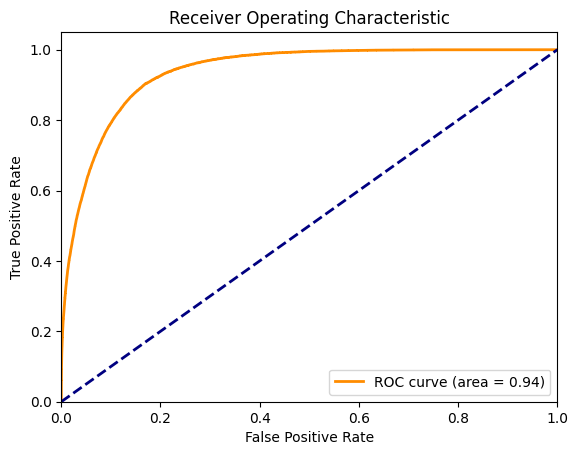

In [43]:
plot_roc_curve(fpr_xgb, tpr_xgb, roc_auc_xgb)

### Hyperparameters optimisation

In [53]:
pipeline_xgb_b = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                booster="gbtree",
                objective="reg:squarederror",
                tree_method="gpu_hist",
            ),
        ),
    ]
)

In [55]:
search_spaces = {
    "learning_rate": Real(0.01, 1.0, "uniform"),
    "max_depth": Integer(2, 12),
    "subsample": Real(0.1, 1.0, "uniform"),
    "colsample_bytree": Real(0.1, 1.0, "uniform"),  # subsample ratio of columns by tree
    "reg_lambda": Real(1e-9, 100.0, "uniform"),  # L2 regularization
    "reg_alpha": Real(1e-9, 100.0, "uniform"),  # L1 regularization
    "n_estimators": Integer(50, 5000),
}

scoring = make_scorer(
    partial(mean_squared_error, squared=False), greater_is_better=False
)

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)

cv_strategy = list(skf.split(X_train, y_train))

opt = BayesSearchCV(
    estimator=pipeline_xgb_b,
    search_spaces=search_spaces,
    scoring=scoring,
    cv=cv_strategy,
    n_iter=120,  # max number of trials
    n_points=1,  # number of hyperparameter sets evaluated at the same time
    n_jobs=1,  # number of jobs                                    # if not iid it optimizes on the cv score
    return_train_score=False,
    refit=False,
    optimizer_kwargs={
        "base_estimator": "GP"
    },  # optmizer parameters: we use Gaussian Process (GP)
    random_state=0,
)